In [1]:
setwd('/import/hd/')

In [2]:
sce = readRDS('./SCE.rds')

In [3]:
table(sce$orig.ident)


  N2  OA7 
1308 2982 

In [4]:
Idents(sce) = 'orig.ident'

In [ ]:
OA7 = subset(sce,ident = 'OA7')

OA7@images$slice1.1.1 = NULL



Idents(OA7) ='seurat_clusters'

OA7$celltype = paste0('C',OA7$seurat_clusters)

Idents(OA7) ='celltype'

SpatialDimPlot(OA7, cells.highlight = CellsByIdentities(object = OA7, idents = c('C3'))) 

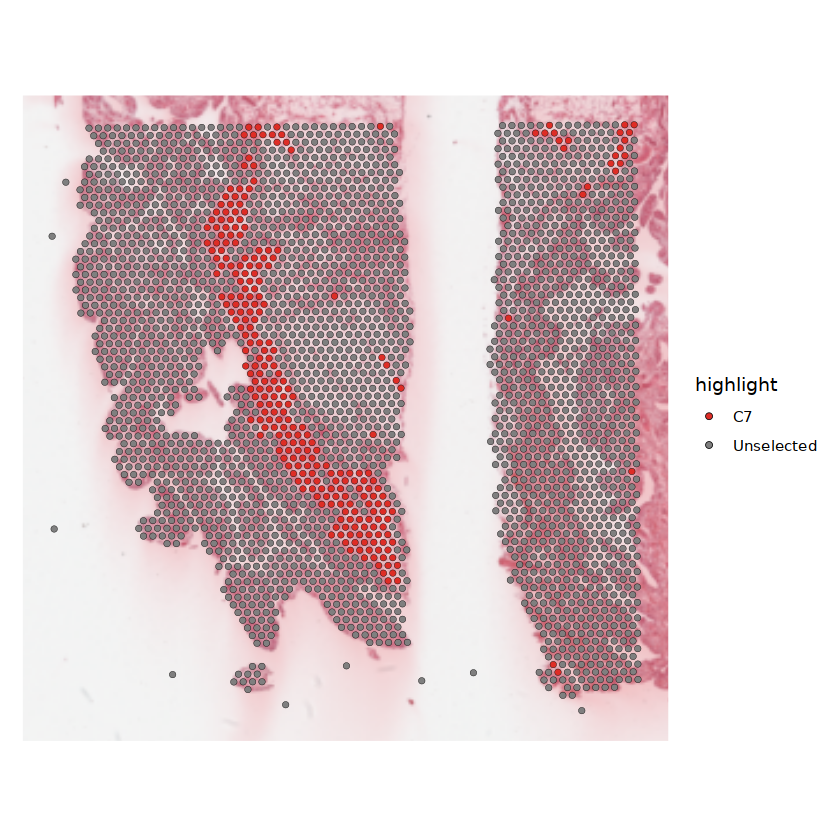

In [31]:
SpatialDimPlot(OA7, cells.highlight = CellsByIdentities(object = OA7, idents = c('C7'))) 

In [33]:
data.input = GetAssayData(OA7, slot = "data", assay = "SCT")

In [34]:
meta = data.frame(labels = Idents(OA7), row.names = names(Idents(OA7)))

In [36]:
visium.brain = OA7

In [37]:
spatial.locs = GetTissueCoordinates(visium.brain, scale = NULL, cols = c("imagerow", "imagecol")) 

In [39]:
scale.factors = jsonlite::fromJSON(txt = file.path("/import/hd/OA7/spatial", 'scalefactors_json.json'))
scale.factors = list(spot.diameter = 65, spot = scale.factors$spot_diameter_fullres, # these two information are required
                     fiducial = scale.factors$fiducial_diameter_fullres, hires = scale.factors$tissue_hires_scalef, lowres = scale.factors$tissue_lowres_scalef # these three information are not required
)


In [42]:
library(CellChat)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [43]:
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels",
                           datatype = "spatial", coordinates = spatial.locs, scale.factors = scale.factors)

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial imaging data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  C7 C6 C1 C11 C2 C3 C4 C5 C0 C8 C9 C10 


In [74]:
CellChatDB <- CellChatDB.human

In [45]:
#CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 

In [75]:
CellChatDB.use = CellChatDB

In [76]:
cellchat@DB <- CellChatDB.use

In [77]:
library(future)

In [82]:
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
plan(multisession, workers=20)

In [83]:
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

In [84]:
cellchat <- projectData(cellchat, PPI.human)

In [95]:
cellchat

An object of class CellChat created from a single dataset 
 18035 genes.
 2982 cells. 
CellChat analysis of spatial data! The input spatial locations are 
                     x_cent y_cent
AACACTTGGCAAGGAA-1_1  22994   8671
AACAGGAAGAGCATAG-1_1  26752  15048
AACAGTCAGGCTCCGC-1_1  18980  15096
AACAGTCCACGCGGTG-1_1  16911  14686
AACATACTCATATGCG-1_1  23470  15125
AACATAGTCTATCTAC-1_1  24864  13150

In [ ]:
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1, 
                               distance.use = TRUE, interaction.length = 200, scale.distance = 0.01)

truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on spatial imaging data using distances as constraints <<< [2024-07-31 00:00:39]"
The suggested minimum value of scaled distances is in [1,2], and the calculated value here is  1.401345 


In [ ]:
cellchat <- filterCommunication(cellchat, min.cells = 3)

In [ ]:
cellchat <- computeCommunProbPathway(cellchat)

In [ ]:
cellchat <- aggregateNet(cellchat)

In [ ]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = rowSums(cellchat@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = rowSums(cellchat@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [ ]:
p1 <- netVisual_heatmap(cellchat, measure = "count", color.heatmap = "Blues")
p2 <- netVisual_heatmap(cellchat, measure = "weight", color.heatmap = "Blues")
p1 + p2

In [ ]:
par(mfrow=c(1,1), xpd = TRUE)# xpd = TRUE以显示标题
pathways.show <- c("SPP1")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
 
#在空间转录组学上显示信号网络
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "spatial", edge.width.max = 2,vertex.size.max = 1, alpha.image = 0.2, vertex.label.cex = 3.5)

In [89]:
getwd()

[1] "/import/hd"